In [1]:
import numpy as np
import matplotlib.image as mpimg 
import matplotlib.pyplot as plt 
from matplotlib import style
style.use('fivethirtyeight')

import cv2 
import os
from PIL import Image
from PIL import ImageEnhance
import sys
import re
# from sklearn.datasets.samples_generator import make_blobs
from scipy.stats import multivariate_normal
from sklearn.mixture import GaussianMixture

%matplotlib inline 

In [2]:
###################################################

def get_bg_color(matrix, bits_per_channel=None):

    unique, counts = np.unique(matrix, return_counts=True)
    mode = unique[counts.argmax()]
    return mode


def get_bg_colors(matrix, options, bits_per_channel=None):

    unique, counts = np.unique(matrix, return_counts=True)
    total_count = sum(counts)
    
    division = unique // 32
    countsDiv = [sum([counts[i] for i, x in enumerate(division) if x == j]) for j in range(8)]
    print([round(x, 2) for x in countsDiv / total_count])
    plt.plot(unique, counts)
    
    print(counts)
    
    modes = np.array([i for i, x in enumerate(countsDiv) if x / total_count > options.bg_threshold])
    rt = modes * 32 + 4
    plt.axvline(x = [min(rt)])

    plt.show()
    
    return rt
######################################################################

def percent(string):
    '''Convert a string (i.e. 85) to a fraction (i.e. .85).'''
    return float(string)/100.0

###################################################

def get_min_diff(bg_colors):
    def helper(x):
        return min(abs(bg_colors - x))
    return helper

def get_bg_mask(bg_colors, matrix, options):
    return np.vectorize(get_min_diff(bg_colors))(matrix) <= options.value_threshold

def notescan_main(options, matrix):

    bg_colors = get_bg_colors(matrix, options)
    print(bg_colors)
#     bg_mask = get_bg_mask(bg_colors, matrix, options)
    matrix[matrix > min(bg_colors) - options.value_threshold] = 255

    return matrix

class Options:
    value_threshold = 15
    bg_threshold = 0.2
    sample_fraction = 100


def rmbg(matrix):
    options = Options()
    return notescan_main(options, matrix)

In [3]:
# Default algorithmic parameters
stride = 20;                 # Number of pixels to skip when performing local analysis
blockSize = stride;              # Size of overlapping blocks in local analysis
numOfClusters = 4;           # Number of clusters used for local analysis
numOfClustersRef = 4;        # Number of clusters used for global analysis  
maxIters = 100;              # Maximum number of iterations used as stopping condition for GMM clustering. 
emEps = 0.1;                # Epsilon threshold used as stopping condition for GMM clustering.
dsFactor = 1.0;             # No downsampling is done
numOfLocalSamples = 150;     # Number of samples to take in each block (for local statistics)
numOfGlobalSamples = 1000;   # Number of samples to take throughout entire image (for global statistics)
diffThres = 30;
clearThres = 40;
probThres = 0.3;


def GetBlock(x, y, dsImage, width, height):

    # Find bounds around center pixel
    minX = x
    maxX = min(width, x + blockSize);
    minY = y
    maxY = min(height, y + blockSize);
    
    # Copy intensities to block
    block = np.array([dsImage[y][minX:maxX] for y in range(minY, maxY)])

    return block;

def PutBlock(x, y, newImg, newBlock):
    for i in range(y, y + len(newBlock)):
        newImg[i][x:x+len(newBlock[i - y])] = newBlock[i - y]

def ClusterBlock(block):
#     X,Y = make_blobs(cluster_std=0.5,random_state=20,n_samples=1000,centers=5)
    # Stratch dataset to get ellipsoid data
    emModel = GaussianMixture(n_components=numOfClusters, covariance_type= 'diag', max_iter=maxIters, tol=emEps)
    
    originalShape = (len(block), -1)
    
    block_flat = block.reshape((-1, 1))
    if len(block_flat) < numOfClusters:
        dst = np.zeros_like(block)
        cv2.normalize(block, dst, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)
        return None, None, dst
    samples = block_flat.copy()
    samples = np.array(samples)
    emModel.fit(samples)
    predict_probs = emModel.predict_proba(samples)
    
    means = emModel.means_ 
    
    covariances = emModel.covariances_
    
    order = sorted(range(len(means)), key = lambda x : means[x])
    means = np.array(sorted(means))
    predict_probs = np.array([[p[o] for o in order] for p in predict_probs])
        
    if (abs(means[0] - means[-1]) < clearThres):
        predicts = np.ones(len(predict_probs))
        
    else:
        lowest = means[0]
        highest = means[-1]
        values = np.array([int(abs(m - lowest) >= diffThres) * 1 * int(abs(m - highest) < diffThres) + min(1, 1.1 * (m - lowest) / (highest - lowest)) * int(abs(m - highest) >= diffThres and abs(m - lowest) >= diffThres) for m in means])
        predicts = []
        for p in predict_probs:
            predicts.append(np.dot(p, values))
        predicts = np.array(predicts)
    
    
    predicts = np.array([predicts * 255])
    
    
    return means, covariances, predicts.reshape(originalShape)
    
def UpsampleShadowMap(shadowMap, width, height):
    return cv2.resize(shadowMap, (width, height), interpolation = cv2.INTER_LANCZOS4)

def DownsampleShadowMap(shadowMap):
    return cv2.resize(shadowMap, (0, 0), fx=dsFactor, fy=dsFactor, interpolation = cv2.INTER_LANCZOS4)

# main function
def RemoveShadow(image):
#     global blockSize, stride
    
    
    width = len(image[0])
    height = len(image)
    
#     stride = min(width, height) // 10
#     blockSize = max(width, height) // 10
    
    print("Clustering...")
    dsImage = image.copy()
    width = len(dsImage[0])
    height = len(dsImage)
    print(height, width)
    
    newImg = image.copy()
    
    num = 0
    
    i = 0
    while i < height:
        j = 0
        while j < width:
#             print(i, j)
            block = GetBlock(j, i, dsImage, width, height)
#             display(Image.fromarray(block, "L"))

            means, covariances, newBlock = ClusterBlock(block)
            
            PutBlock(j, i, newImg, newBlock)
            
            j += stride
        i += stride
        new_num = int(100 * round(i / height, 1) // 10)
        if new_num != num:
            num = new_num
            print('>' * new_num + "-" * (10 - new_num))
    print("    done")
    return newImg



In [8]:
def sigmoid(x):
    return 1 / (1 + np.e ** (-1/100 * x))

def relu(x):
    return np.maximum(x, 0)

def upperlu(x):
    return np.minimum(x, 0)

def doublelu(x):
    k = 100
    return np.maximum(np.minimum(x, k), -k)

def rescale(matrix):
    display(Image.fromarray(matrix, "L"))
    matrix = matrix - np.min(matrix)
    display(Image.fromarray(matrix, "L"))
    display(Image.fromarray(matrix * 255 // 216, "L"))
    matrix = (matrix * 255 / np.max(matrix)).astype(int)
    display(Image.fromarray(matrix, "L"))
    return matrix

def findMatrices(matrix, edge):
    matrices = [matrix]
    left = [matrix]
    right = [matrix]
    bot = [matrix]
    top = [matrix]
    
    moveRight = lambda m: np.insert(np.delete(m,0,1), -1, 0, axis=1)
    moveLeft = lambda m: np.insert(np.delete(m,-1,1), 0, 0, axis=1)
    moveTop = lambda m: np.insert(np.delete(m,-1,0), 0, 0, axis=0)
    moveBot = lambda m: np.insert(np.delete(m,0,0), -1, 0, axis=0)
    
    for i in range(1, edge + 1):
        for _ in range(len(right)):
            
            m = right.pop(0)
            m = moveRight(m)
            right.append(m)
            matrices.append(m)
        for _ in range(len(left)):
            m = left.pop(0)
            m = moveLeft(m)
            left.append(m)
            matrices.append(m)
        for _ in range(len(top)):
            m = top.pop(0)
            m = moveTop(m)
            top.append(m)
            matrices.append(m)
        for _ in range(len(bot)):
            m = bot.pop(0)
            m = moveBot(m)
            bot.append(m)
            matrices.append(m)
            
        leftTop = moveTop(left[0])
        left.insert(0, leftTop)
        top.insert(0, leftTop)
        matrices.append(leftTop)
        
        rightTop = moveTop(right[0])
        right.insert(0, rightTop)
        top.append(rightTop)
        matrices.append(rightTop)
        
        leftBot = moveBot(left[-1])
        left.append(leftBot)
        bot.insert(0, leftBot)
        matrices.append(leftBot)
        
        rightBot = moveTop(right[-1])
        right.append(rightBot)
        top.append(rightBot)
        matrices.append(rightBot)
    return matrices
    
def contrast_img(matrix):
    
    dst = np.zeros_like(matrix)
    cv2.normalize(matrix, dst, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)
    
    matrix = dst
#     print(matrix)
    
    edge = 2
    
    matrices = findMatrices(matrix, edge)
    
    mean_matrix = np.sum(matrices, axis=0) / len(matrices)
    demean_matrices = np.array(matrices) - mean_matrix
    std_matrix = np.sum(demean_matrices ** 2, axis=0) ** 0.5
    mean_std = np.mean(std_matrix)
    
    judge_matrix_dark = np.where((matrix < mean_matrix) & (std_matrix > 0.8 * mean_std), matrix, 0)
#     judge_matrix_bright = np.where((matrix > 1.1 * mean_matrix) & (std_matrix > mean_std), matrix, 0)
#     display(Image.fromarray(judge_matrix_dark.astype('uint8'), "L"))
    matrix = (matrix - 0.5 * judge_matrix_dark).astype('uint8')
    
    return matrix

def init_resize(img):
    while len(img) > 1500 or len(img[0]) > 1500:
        img = cv2.resize(img, (int(len(img[0]) / 1.5), int(len(img) / 1.5)))
    return img

def denoiseOnce(matrix, e):
    print(e)
    matrices = findMatrices(matrix, e)
    count_black = np.zeros_like(matrix).astype('int64')
    thres = min(e * 2, len(matrices) // 8)
    for m in matrices:
        count_black += np.where(m.astype('int64') < 200, 1, 0)

    matrix = np.where(count_black > thres, matrix, 255).astype('uint8')
#     Image.fromarray(matrix).show()
    return matrix

def denoise(matrix, edge = 2):
    for e in range(1, edge + 1):
        matrix = denoiseOnce(matrix, e)
    for e in range(edge - 1, 0, -1):
        matrix = denoiseOnce(matrix, e)
    rt = np.zeros_like(matrix).astype('int64')
    while not np.array_equal(rt, matrix):
        rt = matrix
        matrix = denoiseOnce(matrix, 1)
    return matrix
    

def generateGray(img):
    img = init_resize(img)
    matrix = np.array(img) 
    matrix = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    matrix = cv2.GaussianBlur(matrix, (7, 7), 0.6)
#     matrix = cv2.medianBlur(matrix, 3)
#     Image.fromarray(matrix).show()
#     display(Image.fromarray(matrix, "L"))
    matrix = contrast_img(matrix)
    display(Image.fromarray(matrix, "L"))
    matrix = RemoveShadow(matrix)
#     Image.fromarray(matrix, "L").show()
    rt = np.zeros_like(matrix).astype('int64')
    edge = min(min(len(matrix), len(matrix[0])) // 100, 3)
    print(edge)
    matrix = denoise(matrix, edge)
#     matrix = cv2.medianBlur(matrix, 3)

    varM = cv2.Laplacian(matrix, cv2.CV_64F)
#     matrix = matrix + (varM > 40) * (-20)

    rt = np.array(matrix)


    return rt

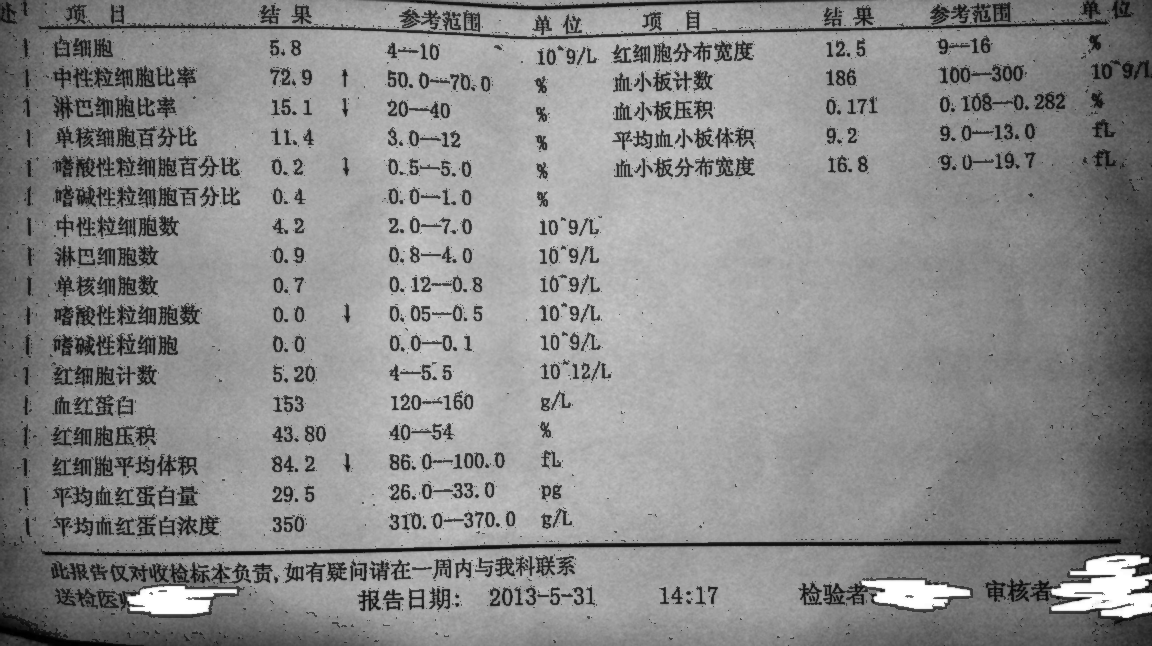

Clustering...
646 1152
>---------
>>--------
>>>-------
>>>>------
>>>>>-----
>>>>>>----
>>>>>>>---
>>>>>>>>--
>>>>>>>>>-
>>>>>>>>>>
    done
3
1
2
3
2
1
1
1
[[254 254 254 ...   0   0   0]
 [254 255 255 ...   4   0   0]
 [254 255 255 ...   1   0   0]
 ...
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]]


In [9]:
img_ori = cv2.imread("../Jerry.in/clahe_2.jpg")
# img = cv2.cvtColor(img_ori, cv2.COLOR_BGR2GRAY)
# Image.fromarray(img, "L").show()
result = generateGray(img_ori)
# _,_,result = ClusterBlock(img)
print(result)
p = Image.fromarray(result, "L")
p.show()

../Jerry.hard.in/psa3.jpg


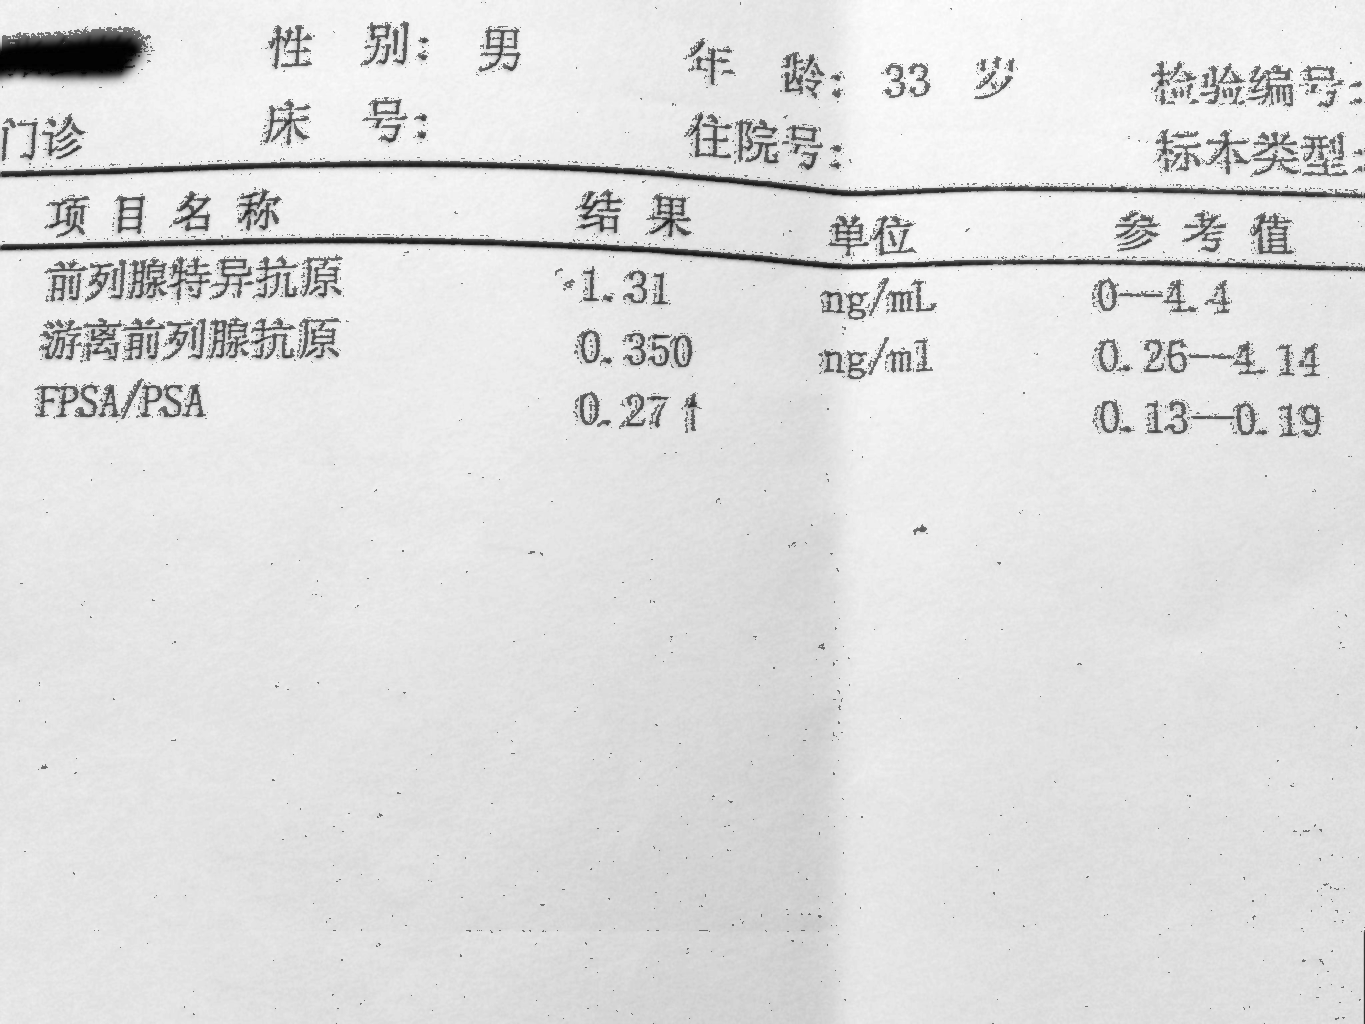

Clustering...
1024 1365
>---------
>>--------
>>>-------
>>>>------
>>>>>-----
>>>>>>----
>>>>>>>---
>>>>>>>>--
>>>>>>>>>-
>>>>>>>>>>
    done
3
1
2
3
2
1
1
1
1
../Jerry.hard.in/labtest4.jpg


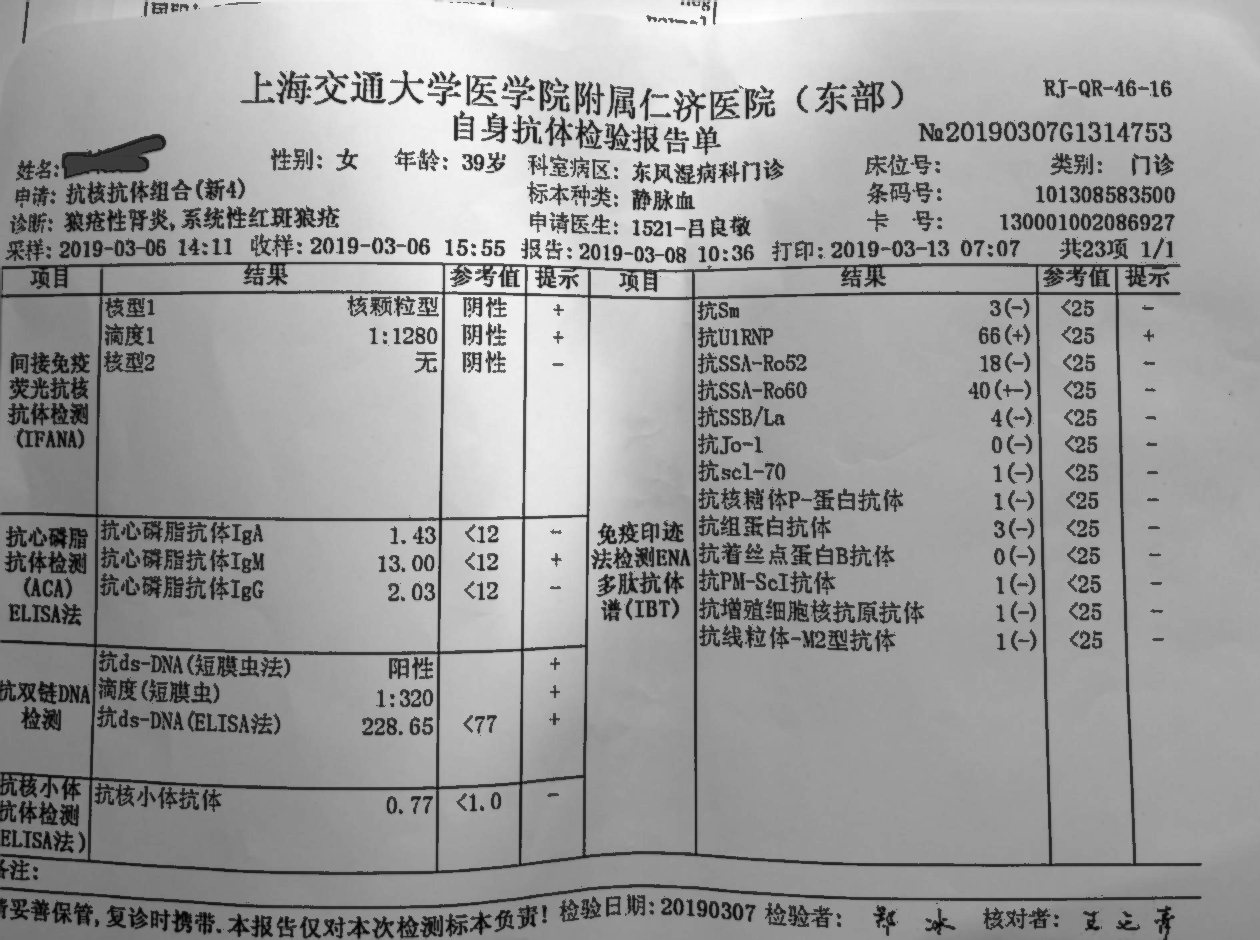

Clustering...
940 1260
>---------
>>--------
>>>-------
>>>>------
>>>>>-----
>>>>>>----
>>>>>>>---
>>>>>>>>--
>>>>>>>>>-
>>>>>>>>>>
    done
3
1
2
3
2
1
1


In [16]:
# Save image in set directory 
# Read RGB image 
p = "../Jerry.hard.in"

matrices = []
for r,d,f in os.walk(p):
    for file_name in f:
        if (not file_name.endswith(".jpeg") and not file_name.endswith(".jpg") and not file_name.endswith(".png")):
            continue
        print(p + "/" + file_name)
        img = cv2.imread(p + "/" + file_name)
#         Image.fromarray(img).show()
#         img = cv2.resize(img, (3840, 2160))
        rt = generateGray(img)
        Image.fromarray(rt).show()
        postfix = file_name.split(".")[-1]
        main_name = ".".join(file_name.split(".")[:-1])
#         of = open('../Jerry.hard.out/' + main_name + ".out." + postfix,"w+")
#         close(of)
        Image.fromarray(rt).save('../Jerry.hard.out/' + main_name + ".out." + postfix, dpi=(70, 70))
        

In [ ]:
# f = open("graymatrix.txt","w+")
# for r in matrix:
#     s = ""
#     for entry in r:
#         s += str(entry) + ", "
#     f.write(s + "\n")
# f.close()

In [11]:
# Save image in set directory 
# Read RGB image 
p = "../Jerry.hard.in"

matrices = []
for r,d,f in os.walk(p):
    for file_name in f:
        if (not file_name.endswith(".jpeg") and not file_name.endswith(".jpg") and not file_name.endswith(".png")):
            continue
        print(p + "/" + file_name)
        img = cv2.imread(p + "/" + file_name)
#         Image.fromarray(img).show()
#         img = cv2.resize(img, (3840, 2160))
#         rt = generateGray(img)
#         Image.fromarray(rt).show()
#         cv2.imwrite('../Jerry.out/' + file_name + '.out.jpg', rt)
        Image.fromarray(img).save(p + "/" + file_name, dpi=(70, 70))
        

../Jerry.hard.in/psa3.jpg
../Jerry.hard.in/labtest4.jpg
